### Imports

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import platform
from pathlib import Path
if platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/'])
    plot_dir = Path("/Users/nkinsky/Documents/UM/Working/Bapun_Data/plots")
else:
    sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy'])
    sys.path.extend(['/home/nkinsky/Documents/GitHubPrivate/pythonprogs/DataPaths/'])
    
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy.utils.mathutil import min_max_scaler
from scipy.ndimage import gaussian_filter1d, gaussian_filter

from neuropy import plotting
from neuropy.analyses.placefields import Pf1D
from neuropy.core.position import Position
from neuropy.plotting import plot_ratemap
from neuropy.plotting.figure import Fig
from neuropy.utils.misc import flatten

import subjects

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Define useful functions

In [3]:
def pf_corr_maze_remaze(row, nbins_each_sesh=50):
    """Calculate PF correlation for each row/neuron. 
    
    row: a DataFrame row of values (or 1d ndarray) where the first nbins_each_sesh bins 
    are firing rates for MAZE in each bin and the next nbins_each_sesh are for reMAZE"""
    maze_tc = row.values[0:nbins_each_sesh]
    remaze_tc = row.values[nbins_each_sesh:]
    

    return np.corrcoef([maze_tc, remaze_tc])[0, 1]

In [4]:
def get_pf_loc(row, nbins_each_sesh=50, end_prop=0.125):
    """Calculate placefield peak location
    
    row: a DataFrame row of values (or 1d ndarray) where the first nbins_each_sesh bins 
    are firing rates for MAZE in each bin and the next nbins_each_sesh are for reMAZE
    
    end_prop: propotion of the track corresponding to end - fields with locations less than end_prop or 
    more than 1 - end_prop are classified as 'end' pfs while the rest are classified as 'middle' pfs"""

    # Get location on track
    maze_tc = row.values[0:nbins_each_sesh]
    imax = np.argmax(maze_tc)
    
    if (imax < (nbins_each_sesh * end_prop)) | (imax > (nbins_each_sesh - nbins_each_sesh * end_prop)):
        loc = "end"
    else:
        loc = "middle"

    return loc

In [5]:
def pf_corr_maze_remaze_ends(row, nbins_each_sesh=50, end_prop=0.125):
    """Calculate PF correlation for each row/neuron but only consider neurons with peaks in at the end of the tracks,
    within `end_prop` of the end of the track"""

    # Calculate correlations
    pf_corr_row = pf_corr_maze_remaze(row, nbins_each_sesh=nbins_each_sesh)

    # Get location on track
    maze_tc = row.values[0:nbins_each_sesh]
    imax = np.argmax(maze_tc)

    if (imax < (nbins_each_sesh * end_prop)) | (imax > (nbins_each_sesh - nbins_each_sesh * end_prop)):
        return pf_corr_row
    else:
        return np.nan


In [6]:
def pf_corr_maze_remaze_middle(row, nbins_each_sesh=50, end_prop=0.125):
    """Calculate PF correlation for each row/neuron but only consider neurons with peaks in at the end of the tracks,
    within `end_prop` of the end of the track"""

    # Calculate correlations
    pf_corr_row = pf_corr_maze_remaze(row, nbins_each_sesh=nbins_each_sesh)

    # Get location on track
    maze_tc = row.values[0:nbins_each_sesh]
    imax = np.argmax(maze_tc)

    if (imax > (nbins_each_sesh * end_prop)) & (imax < (nbins_each_sesh - nbins_each_sesh * end_prop)):
        return pf_corr_row
    else:
        return np.nan


In [7]:
def get_imax(row):
    maze_tc = row.values[0:nbins_each_sesh]
    imax = np.argmax(maze_tc)

    return imax

In [8]:
def delta_rate_index(row, nbins_each_sesh=50, use_same_peak_bin=False):
    """Calculate change in max firing rate from MAZE to REMAZE for each row/neuron"""
    maze_tc = row.values[0:nbins_each_sesh]
    remaze_tc = row.values[nbins_each_sesh:]
    
    maze_max = np.nanmax(maze_tc)
    remaze_max = np.nanmax(remaze_tc)
    if use_same_peak_bin:
        imax = np.argmax(maze_tc)
        remaze_max = remaze_tc[imax]
    
    return (maze_max - remaze_max) / (maze_max + remaze_max)

In [9]:
def delta_pf_peak(row, nbins_each_sesh=50):
    maze_tc = row.values[0:nbins_each_sesh]
    remaze_tc = row.values[nbins_each_sesh:]

    return np.argmax(maze_tc) - np.argmax(remaze_tc)

In [10]:
def get_number_of_fields(pf_peak_or_width_list):
    nfields = [cell_peaks.size if ~np.all(np.isnan(cell_peaks)) else 0 for cell_peaks in pf_peak_or_width_list]

    return nfields

### NRK TODO:
0) Run sanity checks on PF construction - are we combining each way or keeping separate? Is that the best method? What if the rat flips the direction around after SD?
1) Remove bad SD sessions with only a few remaze laps
2) Figure out why there is more rate-remapping in the same position bin for SD than NSD but ONLY WHEN I normalize each maze to itself.

### Visualize running behavior for all rats and tally lap #s by hand

In [11]:
#1st # = maze trials, 2nd # = remaze trial, 2 trials = 1 lap up/down
ntrials_dict = {"RatUDay2": [25, 17], "RatVDay1": [23, 30], "RatVDay3": [163, 103],
                "RatSDay3": [23, 16], "RatUDay1": [54, 4], "RatUDay4": [32, 4],
                "RatVDay2": [79, 92], "RatRDay2": [41, 10]}
sessions = subjects.remaze_sess()[1:]  # RatSDay2NSD does not have remaze position info

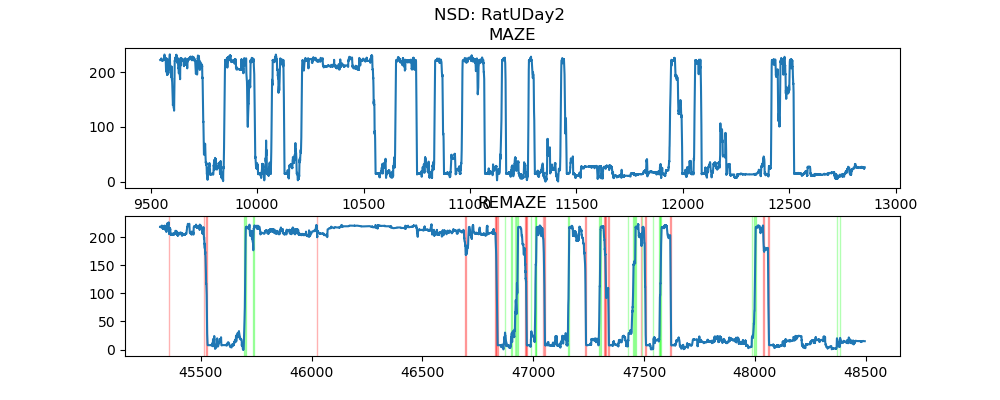

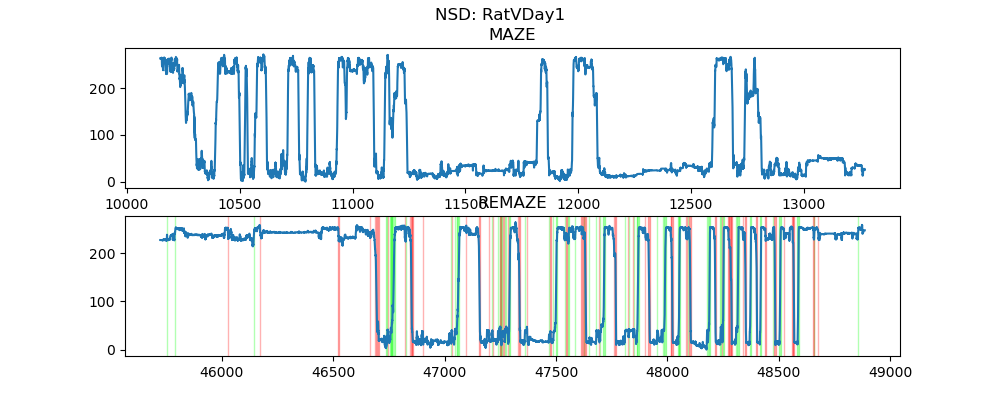

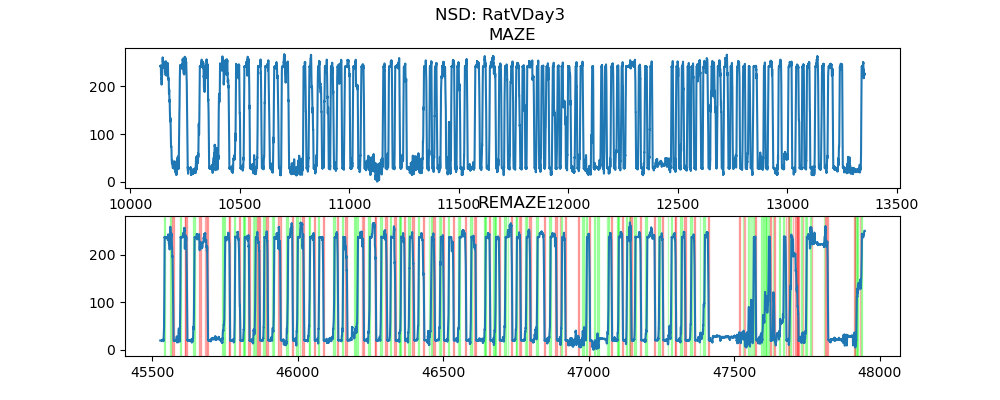

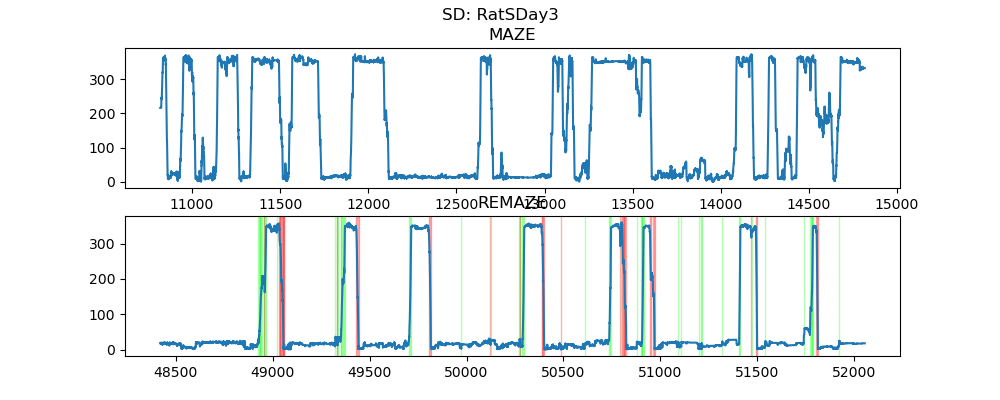

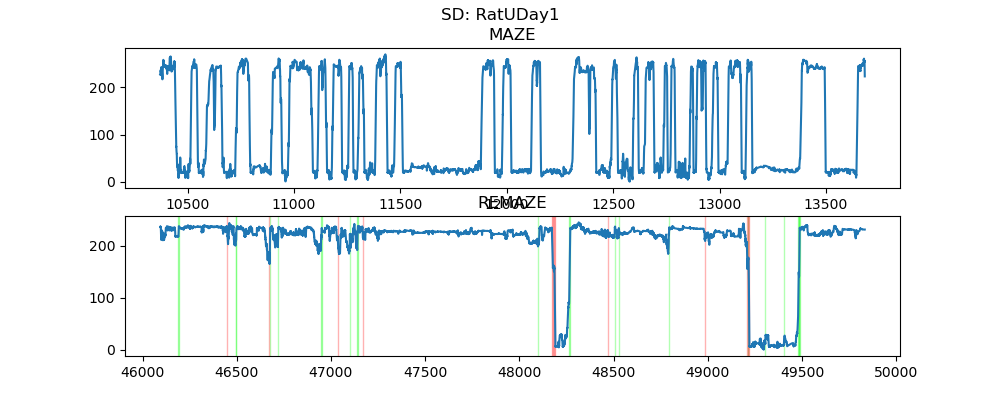

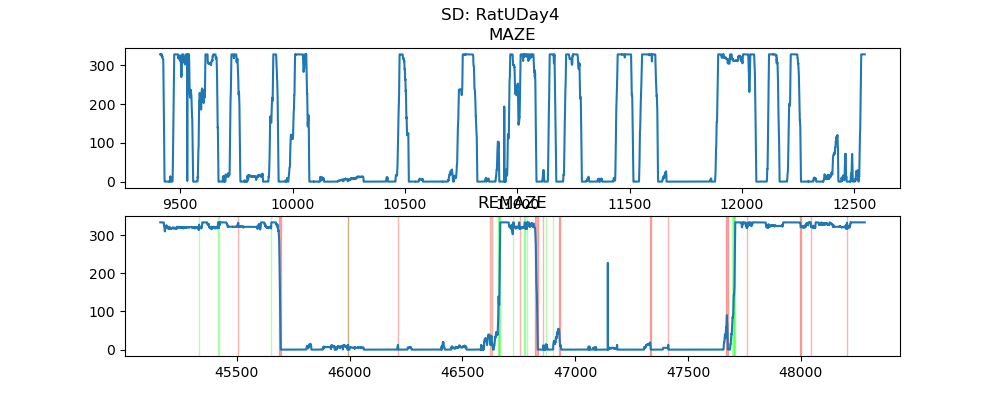

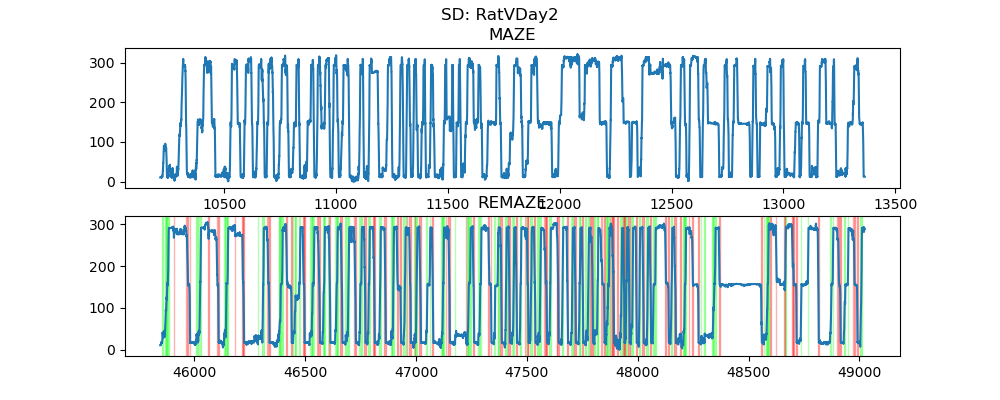

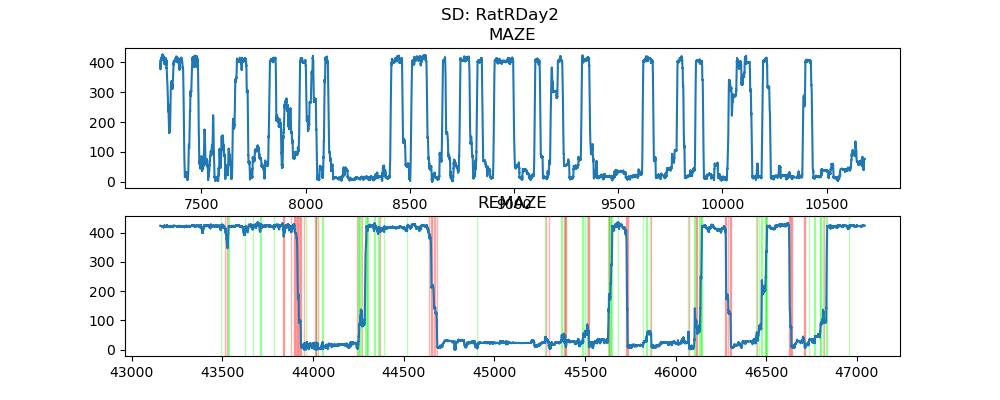

In [12]:
%matplotlib widget
for sess in subjects.remaze_sess()[1:]:
    fig, ax = plt.subplots(2, 1, figsize=(10, 4))
    fig.suptitle(f"{sess.tag}: {sess.name}")
    ax[0].plot(sess.maze.time, sess.maze.x)
    ax[0].set_title("MAZE")
    ax[1].plot(sess.remaze.time, sess.remaze.x)
    ax[1].set_title("REMAZE")
    for col, dir in zip([[0, 1, 0, 0.3], [1, 0, 0, 0.3]], ["up", "down"]):
        for start, stop in zip(sess.remaze_run[dir].starts, sess.remaze_run[dir].stops):
            ax[1].axvspan(start, stop, color=col)

### Phase precession

In [14]:
# Load in test session
sess = sessions[0]
maze = sess.paradigm["maze"].flatten()
remaze = sess.paradigm["re-maze"].flatten()
neurons = sess.neurons_stable.get_neuron_type("pyr")
kw = dict(frate_thresh=0, grid_bin=5)
signal = sess.theta

pfremaze = Pf1D(neurons, position=sess.remaze, **kw)

pfmaze = Pf1D(neurons, position=sess.maze, **kw)

In [43]:
sess.neurons.spiketrains[0][-1]/60



808.3085972222221

In [45]:
0.30859*60

18.5154

In [37]:
sess.best_channels

BestChannels(theta=170, slow_wave=187)

In [31]:
t = [map_ / np.max(map_) if len(map_) > 0 else np.array([]) for map_ in ratemaps]
t[8]

array([], dtype=float64)

In [ ]:
pfmaze.r

In [22]:
ratemaps = pfmaze.ratemap_spiketrains
for idm, map_ in enumerate(ratemaps):
    map_ / np.max(map_)

ValueError: zero-size array to reduction operation maximum which has no identity

In [32]:
pfmaze.plot_with_phase()

AttributeError: 'Pf1D' object has no attribute 'ratemap_spiketrains_phases'

### Placefields and population vector correlation MAZE vs REMAZE

Methodology for getting placefield plots below
1) Grab stable pyramidal neurons
2) Break up each session into run directions
3) Calculate place field for each cell x run direction combination. Note that this results in **doubling your neuron count in all figures below!**

In [13]:
### Downsample test code
sess = sessions[0]
maze = sess.paradigm["maze"].flatten()
remaze = sess.paradigm["re-maze"].flatten()
neurons = sess.neurons_stable.get_neuron_type("pyr")
kw = dict(frate_thresh=0, grid_bin=5)

pfremaze = Pf1D(neurons, position=sess.remaze, **kw)

pfmaze = Pf1D(neurons, position=sess.maze, **kw)
    

In [ ]:
def downsample_maze(pfmaze_in: Pf1D, posmaze_in: Position, nframes_run_match: int, **kw):
    """Downsample pfmaze_in analyses.placefield.Pf1D object to match the input number of frames"""
    # Find frame/time in maze when #frames run is equal to remaze
    maze_speed_bool = pfmaze_in.speed > pfmaze_in.speed_thresh
    cumsum_maze_run = np.cumsum(maze_speed_bool)
    try:
        run_match_frame = np.where(cumsum_maze_run == nframes_run_match)[0].min()
    except ValueError: # Don't downsample if rat runs more in remaze than maze
        run_match_frame = maze_speed_bool.shape[0]
    # maze_speed_bool[:run_match_frame].sum()
    
    # Cut down on maze time
    t_stop_ds = pfmaze_in.t[run_match_frame]
    maze_pos_ds = posmaze_in.time_slice(t_start=pfmaze.t_start, t_stop=t_stop_ds)
    # maze_times_ds = sess.paradigm["maze"].flatten()
    # # print(maze_times_ds)
    # maze_times_ds[1] = pfmaze.t[run_match_frame]
    # # print(maze_times_ds)
    
    # re-run maze with downsampling
    # pfmaze = Pf1D(neurons, position=sess.maze, **kw)
    pfmaze_out_ds = Pf1D(neurons, position=maze_pos_ds, **kw)

    return pfmaze_out_ds

# Calculate running frames in remaze
remaze_speed_bool = pfremaze.speed > pfremaze.speed_thresh
nframes_run_remaze = remaze_speed_bool.sum()

pfmaze_ds = downsample_maze(pfmaze, sess.maze, nframes_run_remaze, **kw)

_, ax = plt.subplots(1, 2)
sort_ind = np.argsort(np.argmax(pfmaze.tuning_curves, axis=1))
plot_ratemap(pfmaze, normalize_tuning_curve=True, sortby=sort_ind, ax=ax[0])
ax[0].set_title("All Data")
plot_ratemap(pfmaze_ds, normalize_tuning_curve=True, sortby=sort_ind, ax=ax[1])
ax[1].set_title("Downsampled to Match")

In [ ]:
# Calculate mean #frames in each session in remaze - # frames MAZE / # frames reMAZE are very similar between groups

nframes_run_nsd_at_60hz, nframes_run_sd_at_60hz = [], []
nframes_run_nsd_maze_at_60hz, nframes_run_sd_maze_at_60hz = [], []
for sess in sessions:
    maze = sess.paradigm["maze"].flatten()
    remaze = sess.paradigm["re-maze"].flatten()
    neurons = sess.neurons_stable.get_neuron_type("pyr")
    pfremaze = Pf1D(neurons, position=sess.remaze, **kw)
    pfmaze = Pf1D(neurons, position=sess.maze, **kw)
    
    # Calculate running frames in remaze
    remaze_speed_bool = pfremaze.speed > pfremaze.speed_thresh
    nframes_run_match = remaze_speed_bool.sum()
    nframes_match_60hz = int(nframes_run_match * 60 / sess.remaze.sampling_rate)

    maze_speed_bool = pfmaze.speed > pfmaze.speed_thresh
    nframes_run_match_maze = maze_speed_bool.sum()
    nframes_match_maze_60hz = int(nframes_run_match_maze * 60 / sess.maze.sampling_rate)
    
    if sess.tag == "NSD":
        nframes_run_nsd_at_60hz.append(nframes_match_60hz)
        nframes_run_nsd_maze_at_60hz.append(nframes_match_maze_60hz)
    elif sess.tag == "SD":
        nframes_run_sd_at_60hz.append(nframes_match_60hz)
        nframes_run_sd_maze_at_60hz.append(nframes_match_maze_60hz)
        
print(f"NSD frames run during remaze = {nframes_run_nsd_at_60hz}")
print(f"SD frames run during remaze = {nframes_run_sd_at_60hz}/n")

print(f"NSD frames run during maze = {nframes_run_nsd_maze_at_60hz}")
print(f"SD frames run during maze = {nframes_run_sd_maze_at_60hz}/n")

#### Workhorse code below to aggregate place fields

In [ ]:
pfmaze.neuron_ids

In [ ]:
from scipy.signal import find_peaks, peak_widths
def pf_widths(pf_in: Pf1D, rel_height_thresh: float = 0.5, dist_thresh:float = 10, smooth_sigma=1, 
              keep: str in ['all', 'peak_only'] = 'peak_only', sanity_check_plot: bool = False):
    """Note this is also in the Pf1D class, kept here for ease."""
 
    pf_tc_smooth = gaussian_filter1d(pf_in.tuning_curves, sigma=smooth_sigma, axis=1) if (smooth_sigma > 0) else pf_in.tuning_curves

    widths = []
    for idt, (tc, peak_loc) in enumerate(zip(pf_tc_smooth, pf_in.peak_locations())):
        peaks, _ = find_peaks(tc, distance=dist_thresh, rel_height=rel_height_thresh)
        biggest = np.argmax(tc)
        if keep == 'peak_only':
            try:
                peaks = [peaks.flat[np.abs(peaks - biggest).argmin()]]
            except ValueError:
                peaks = peaks
        print(peaks)
        width_results = peak_widths(tc, peaks=peaks, rel_height=rel_height_thresh)
        # print(type(width_results[0]))
        widths.append(width_results[0].squeeze() if width_results[0].size > 0 else np.array(np.nan))

    if sanity_check_plot:  # plot last neuron
        _, ax = plt.subplots(2, 1, height_ratios=[4, 1], sharex=True)
        ax[0].plot(tc)
        ax[0].plot(peaks, tc[peaks], 'r.')
        ax[0].plot(peak_loc, tc[peak_loc], 'g*')
        ax[0].plot(biggest, tc[biggest], 'co', markerfacecolor=None)
        ax[0].hlines(*width_results[1:], 'r')
        ax[0].set_ylabel('Firing rate (Hz)')
    
        pf_in.plot_ratemaps_raster(jitter=0.1, scale='tuning_curve', sort=False, plot_time=True, ax=ax[1])
        ax[1].set_xlabel(f"Bin # ({pf_in.x_binsize} cm bins)")
        ax[1].set_ylim([idt - 0.5, idt + 0.5])
        ax[1].set_yticks([])
        sns.despine(left=True, ax=ax[1])
    
    return widths

sess = sessions[0]
remaze = sess.paradigm["re-maze"].flatten()
neurons = sess.neurons_stable.get_neuron_type("pyr")
pfremaze = Pf1D(neurons, position=sess.remaze, **kw)

pf_widths(pfremaze.neuron_slice([7]), keep='all', smooth_sigma=1.5, sanity_check_plot=True)

In [ ]:
pf_tc_smooth

In [ ]:
peaks, _ = find_peaks(pf_tc_smooth.squeeze(), distance=10, rel_height=0.5)

In [ ]:
peaks

In [ ]:
pf_tc_smooth

In [ ]:
right_edge

In [ ]:
pf_tc_smooth

In [ ]:
pf_in.tuning_curves

In [ ]:
pfmaze.neuron_ids

In [ ]:
### Downsample test code
sess = sessions[0]
maze = sess.paradigm["maze"].flatten()
remaze = sess.paradigm["re-maze"].flatten()
neurons = sess.neurons_stable.get_neuron_type("pyr")
kw = dict(frate_thresh=0, grid_bin=5)

pfremaze = Pf1D(neurons, position=sess.remaze, **kw)

pfmaze = Pf1D(neurons, position=sess.maze, **kw)

In [ ]:
from neuropy.externals import peak_prominence2d
from scipy.ndimage import gaussian_filter
pf_in = pfremaze.neuron_slice([0])
smooth_sigma = 1.5
height_thresh = 0.5
pf_tc_smooth = gaussian_filter1d(pf_in.tuning_curves, sigma=smooth_sigma, axis=1) if (smooth_sigma > 0) else pf_in.tuning_curves
pf_2d = gaussian_filter(np.repeat(pf_tc_smooth, 20, axis=0), sigma=[0, 0.2])
_, ax = plt.subplots()
ax.plot(pf_tc_smooth.squeeze(), ".-")

# Get peaks
peaks,idmap,promap,parentmap = peak_prominence2d.getProminence(np.repeat(pf_tc_smooth, 20, axis=0), step=0.1, 
                                                               centroid_num_to_center=1, verbose=False)

# Draw peaks and get widths
pf_widths = []
for kk,vv in peaks.items():
    # Draw peaks
    xii,yii=vv['center']
    z2ii=vv['height']
    pro=vv['prominence']
    z1ii=z2ii-pro
    ax.plot([xii,xii], [z1ii,z2ii],'k:')
    # ax.axhline(z2ii - pro / 2)

    # Calculate edges and widths
    abv_thresh_regions = contiguous_regions(pf_tc_smooth.squeeze() - (z2ii - pro * height_thresh) > 0)
    left_ind, right_ind = abv_thresh_regions[np.array([(xii > lims[0]) & (xii < lims[1]) for lims in abv_thresh_regions])].squeeze()
    left_edge = interp(0, pf_tc_smooth.squeeze()[[left_ind - 1, left_ind]] - (z2ii - pro * height_thresh), [left_ind - 1, left_ind])
    right_edge = interp(0, pf_tc_smooth.squeeze()[[right_ind, right_ind - 1]] - (z2ii - pro * height_thresh), [right_ind, right_ind - 1])
    pf_widths.append(right_edge - left_edge)

    xlims = ax.get_xlim()
    xrange = np.diff(xlims)
    ax.axhline(z2ii - pro * height_thresh, (left_edge - xlims[0]) / xrange, (right_edge - xlims[0]) / xrange, color='r')

In [ ]:
(left_edge - xlims[0]) / xrange

In [ ]:
(right_edge - xlims[1]) / xrange

In [ ]:
from neuropy.utils.mathutil import contiguous_regions
height_thresh = 0.5
vv = peaks[2]
xii,yii=vv['center']
z2ii=vv['height']
pro=vv['prominence']
abv_thresh_regions = contiguous_regions(pf_tc_smooth.squeeze() - (z2ii - pro * height_thresh) > 0)
peak_edge_inds = abv_thresh_regions[np.array([(xii > lims[0]) & (xii < lims[1]) for lims in abv_thresh_regions])].squeeze()
peak_edge_inds

In [ ]:
pf_tc_smooth.squeeze()[[23, 24]] - (z2ii - pro * height_thresh)

In [ ]:
# Bare bones code here - use first for left edge and second for right edge
left_ind, right_ind = peak_edge_inds
left_edge = interp(0, pf_tc_smooth.squeeze()[[left_ind - 1, left_ind]] - (z2ii - pro * height_thresh), [left_ind - 1, left_ind])

right_edge = interp(0, pf_tc_smooth.squeeze()[[right_ind, right_ind - 1]] - (z2ii - pro * height_thresh), [right_ind, right_ind - 1])

[left_edge, right_edge]

In [ ]:
from scipy.interpolate import interp1d

def find_zero_crossings(x):
    indices = np.where((x[1:] >= 0) & (x[:-1] < 0))[0]
    crossings = interp1d(x[indices], x[indices + 1], fill_value="extrapolate")
    return crossings

In [ ]:
pf_tc_smooth.squeeze() - (z2ii - pro * height_thresh)

In [ ]:
x = pf_tc_smooth.squeeze() - (z2ii - pro * height_thresh)
indices = np.where((x[1:] >= 0) & (x[:-1] < 0))[0]
indices
x[indices]

In [ ]:
crossings = find_zero_crossings(pf_tc_smooth.squeeze() - (z2ii - pro * height_thresh))
crossings

In [ ]:
from scipy.optimize import fsolve
fsolve(pf_tc_smooth.squeeze() - (z2ii - pro * height_thresh) > 0, 1)

In [ ]:
abv_thresh_regions[np.array([(xii > lims[0]) & (xii < lims[1]) for lims in abv_thresh_regions])].squeeze()

In [ ]:
int(np.round(xii))

In [ ]:
[vv['col_level'] for kk,vv in peaks.items()]

In [ ]:
peaks[1].keys()

In [ ]:
[vv['prominence'] for kk,vv in peaks.items()]

In [ ]:
from scipy.signal import peak_prominences
prom, leftb, rightb = peak_prominences(pf_tc_smooth.squeeze(), peaks=[11, 21, 32, 43])
prom

In [ ]:
prom, leftb, rightb = peak_prominences(pf_tc_smooth.squeeze(), peaks=peaks_use)
prom

In [ ]:
pf_tc_smooth.shape

In [ ]:
peaks_use = [int(np.round((vv["center"][0]))) for kk,vv in peaks.items()]
peaks_use

In [ ]:
# from scipy import peak_widths
width_results, _, _, _ = peak_widths(pf_tc_smooth.squeeze(), peaks=peaks_use, rel_height=0.5)
# width_results, _, _, _ = peak_widths(pf_tc_smooth.squeeze(), peaks=[11, 21, 32, 43], rel_height=0.5)
# width_results, _, _, _ = peak_widths(pf_tc_smooth.squeeze(), peaks=[0, 21, 43], rel_height=0.5)
width_results

In [ ]:
len(peaks.items())

In [ ]:
pfremaze.coords

In [ ]:
for i in range(pfremaze.n_neurons):
    pf_widths(pfremaze.neuron_slice([i]), keep='all', smooth_sigma=1, sanity_check_plot=True)


In [ ]:
pfmazecopy.ratemap_spiketrains_pos[[0, 8, 19, 26]]

In [ ]:
pfslice = pfmaze.neuron_slice([0, 1, 2, 3, 4, 5, 6])

In [ ]:
pfmazecopy.neuron_ids[[0, 4, 10, 13]]

In [ ]:
pfmazecopy = deepcopy(pfmaze)

In [ ]:
a = []
a.append([1])
a.append([2, 3])
a

### Calculate widths across all sessions!

In [ ]:
maze_widths

In [ ]:
smooth_sigma = 1
keep = 'all'
ht_thresh = 0.5

maze_widths, remaze_widths = [], []
for sess in sessions:
    maze = sess.paradigm["maze"].flatten()
    remaze = sess.paradigm["re-maze"].flatten()
    neurons = sess.neurons_stable.get_neuron_type("pyr")
    pfremaze = Pf1D(neurons, position=sess.remaze, **kw)
    pfmaze = Pf1D(neurons, position=sess.maze, **kw)

    maze_widths.append(pfmaze.get_pf_widths(keep=keep, smooth_sigma=smooth_sigma, rel_height_thresh=ht_thresh))
    remaze_widths.append(pfremaze.get_pf_widths(keep=keep, smooth_sigma=smooth_sigma, rel_height_thresh=ht_thresh))
# delta = [mwidth - rmwidth for mwidth, rmwidth in zip(maze_widths, remaze_widths)]

#### Get and Plot widths

In [ ]:
nsd_bool = ["NSD" in sess.tag for sess in sessions]
nsd_inds = np.where(nsd_bool)[0]
sd_inds = np.where(~np.array(nsd_bool))[0]

nsd_maze_widths = [maze_widths[i] for i in nsd_inds]
nsd_remaze_widths = [remaze_widths[i] for i in nsd_inds]
sd_maze_widths = [maze_widths[i] for i in sd_inds]
sd_remaze_widths = [remaze_widths[i] for i in sd_inds]

fig, axs = plt.subplots(2, 3, figsize=(9, 6))

fig.suptitle(f"Smooth={smooth_sigma}, keep={keep}, ht_thresh={ht_thresh}")
for ax, maze_width_use, remaze_width_use, grp in zip(axs, [nsd_maze_widths, sd_maze_widths], 
                                                     [nsd_remaze_widths, sd_remaze_widths], ["NSD", "SD"]):
    #Plot width histograms
    ax[0].hist(np.hstack(flatten(maze_width_use)), bins=np.arange(0, 25, 1))
    ax[1].hist(np.hstack(flatten(remaze_width_use)), bins=np.arange(0, 25, 1))
    ax[0].set_title("MAZE")
    ax[1].set_title("reMAZE")
    [a.set_xlabel("PF width (cm)") for a in ax[:2]];
    ax[0].set_ylabel(f"{grp}\nCount")

    # Get and plot delta
    if keep == "peak_only":
        delta = np.hstack(flatten(maze_width_use)) - np.hstack(flatten(remaze_width_use))
        ax[2].hist(delta, bins=np.arange(-15, 15, 1))
        ax[2].axvline(np.nanmean(delta), color='r')
        ax[2].set_xlabel(f"$\Delta$ PF width (cm)")
        ax[2].set_title("MAZE - reMAZE")
    else:
        ax[2].text(0.1, 0.5, f"No $\Delta$ with all peaks kept")


#### Get and plot n fields

In [ ]:
nsd_maze_nfields = [get_number_of_fields(maze_widths[i]) for i in nsd_inds]
nsd_remaze_nfields = [get_number_of_fields(remaze_widths[i]) for i in nsd_inds]

In [ ]:
nsd_bool = ["NSD" in sess.tag for sess in sessions]
nsd_inds = np.where(nsd_bool)[0]
sd_inds = np.where(~np.array(nsd_bool))[0]

nsd_maze_nfields = [get_number_of_fields(maze_widths[i]) for i in nsd_inds]
nsd_remaze_nfields = [get_number_of_fields(remaze_widths[i]) for i in nsd_inds]
sd_maze_nfields = [get_number_of_fields(maze_widths[i]) for i in sd_inds]
sd_remaze_nfields = [get_number_of_fields(remaze_widths[i]) for i in sd_inds]

fig, axs = plt.subplots(2, 3, figsize=(9, 6))

fig.suptitle(f"Smooth={smooth_sigma}, keep={keep}, ht_thresh={ht_thresh}")
for ax, maze_n_use, remaze_n_use, grp in zip(axs, [nsd_maze_nfields, sd_maze_nfields], 
                                                     [nsd_remaze_nfields, sd_remaze_nfields], ["NSD", "SD"]):
    #Plot width histograms
    ax[0].hist(np.hstack(flatten(maze_n_use)), bins=np.arange(-0.5, 5.5, 1))
    ax[0].axvline(np.nanmean(np.hstack(flatten(maze_n_use))), color='r')
    ax[1].hist(np.hstack(flatten(remaze_n_use)), bins=np.arange(-0.5, 5.5, 1))
    ax[1].axvline(np.nanmean(np.hstack(flatten(remaze_n_use))), color='r')
    ax[0].set_title("MAZE")
    ax[1].set_title("reMAZE")
    [a.set_xlabel("# Fields per cell") for a in ax[:2]];
    ax[0].set_ylabel(f"{grp}\nCount")

    # # Get and plot delta
    # if keep == "peak_only":
    #     delta = np.hstack(flatten(maze_width_use)) - np.hstack(flatten(remaze_width_use))
    #     ax[2].hist(delta, bins=np.arange(-15, 15, 1))
    #     ax[2].axvline(np.nanmean(delta), color='r')
    #     ax[2].set_xlabel(f"$\Delta$ PF width (cm)")
    #     ax[2].set_title("MAZE - reMAZE")
    # else:
    #     ax[2].text(0.1, 0.5, f"No $\Delta$ with all peaks kept")


In [ ]:
_, ax = plt.subplots(figsize=(4, 0.5))
cell = 0
ax.plot(pfmaze.ratemap_spiketrains_pos[cell], 
        (pfmaze.ratemap_spiketrains[cell] - pfmaze.t_start) / (pfmaze.t_stop - pfmaze.t_start), 
        'k.', markersize=1)

In [ ]:
pfmaze.t_start

In [ ]:
pfmaze.ratemap_spiketrains_pos[0]

In [ ]:
# Params
nid = 13
dist_thresh = 3
rel_height_thresh = 0.5
width = 1
height = 1
prominence = 1

smooth_sigma = 1
sort = False
peak_type = 'all' # 'peak_only' or 'all'

order = pfmaze.get_sort_order(by="index") if sort else np.arange(pfmaze.n_neurons)
pfmaze_tc_smooth = gaussian_filter1d(pfmaze.tuning_curves, sigma=smooth_sigma, axis=1)  # smooth
pfmaze_tc_smooth = pfmaze_tc_smooth[order]  # Re-order by peak firing location

peaks, _ = find_peaks(pfmaze_tc_smooth[nid], distance=dist_thresh, rel_height=rel_height_thresh, width=width, height=height,
                      prominence=prominence)
if peak_type == 'peak_only':
    # peaks = np.array([pfmaze.peak_locations()[order][nid]])
    peaks = [peaks.flat[np.abs(peaks - pfmaze.peak_locations()[order][nid]).argmin()]]
half_results = peak_widths(pfmaze_tc_smooth[nid], peaks=peaks, rel_height=rel_height_thresh)

_, ax = plt.subplots(2, 1, height_ratios=[4, 1], sharex=True)
ax[0].plot(pfmaze_tc_smooth[nid])
ax[0].plot(peaks, pfmaze_tc_smooth[nid][peaks], 'r.')
ax[0].plot(pfmaze.peak_locations()[order][nid], pfmaze.peak_firing_rate()[order][nid], 'g*')
ax[0].hlines(*half_results[1:], 'r')

pfmaze.plot_ratemaps_raster(jitter=0.1, scale='tuning_curve', sort=sort, plot_time=True, ax=ax[1])
ax[1].set_ylim([nid - 0.5, nid + 0.5])
ax[1].set(yticks=[nid - 0.5, nid + 0.5], yticklabels=['start', 'end'])

### Examine firing rates of interneurons in each session

In [ ]:
def calc_rough_uniformity_metric(pf_in):
    metric = []
    for ratemap_spiketrains_pos in pf_in.ratemap_spiketrains_pos:
        res = sstats.ecdf(ratemap_spiketrains_pos/pf_in.coords.max())
        metric.append(np.abs(res.cdf.probabilities - res.cdf.quantiles).sum())

    return np.array(metric)
    
calc_rough_uniformity_metric(pfmaze)

In [ ]:
# Calculate interneuron firing rates
neuron_type = "stable" # 'all' or 'stable'
fr_df = []
for ids, sess in enumerate(sessions):
    assert neuron_type in ("all", "stable")
    neurons_use = sess.neurons if neuron_type == "all" else sess.neurons_stable
    maze = sess.paradigm["maze"].flatten()
    remaze = sess.paradigm["re-maze"].flatten()

    fr_df_maze = neurons_use.time_slice(*maze).to_dataframe()
    fr_df_maze["session_type"] = "MAZE"
    
    fr_df_remaze = neurons_use.time_slice(*remaze).to_dataframe()
    fr_df_remaze["session_type"] = "reMAZE"

    delta_fr = fr_df_maze["mean_frate"] - fr_df_remaze["mean_frate"]
    fr_df_maze["delta_frate_maze_remaze"] = delta_fr
    fr_df_remaze["delta_frate_maze_remaze"] = np.nan
    
    fr_df_temp = pd.concat((fr_df_maze, fr_df_remaze), axis=0)
    fr_df_temp['neuron_id'] = fr_df_temp.index
    
    fr_df_temp["grp"] = sess.tag
    fr_df_temp["session"] = ids

    fr_df.append(fr_df_temp)
    
fr_df = pd.concat(fr_df, axis=0, ignore_index=True)
fr_df

In [ ]:
fr_use = fr_df[fr_df.neuron_type == "inter"]

# Significant drop of inhibition for SD group but not NSD group with paired t-test (for stable neurons only, doesn't hold if we include all)

print(pg.ttest(fr_use[(fr_use.grp == "SD") & (fr_use.session_type == "MAZE")]["mean_frate"],
         fr_use[(fr_use.grp == "SD") & (fr_use.session_type == "reMAZE")]["mean_frate"],
         paired=True))

# sstats.ks_2samp(fr_use[(fr_use.grp == "SD") & (fr_use.session_type == "MAZE")]["mean_frate"],
#                 fr_use[(fr_use.grp == "SD") & (fr_use.session_type == "reMAZE")]["mean_frate"])

# Distribution of interneuron firing rates is different between groups as well (stable neurons only, doesn't hold if we include all)
sstats.ks_2samp(fr_use[(fr_use.grp == "SD") & (fr_use.session_type == "MAZE")]["delta_frate_maze_remaze"],
                fr_use[(fr_use.grp == "NSD") & (fr_use.session_type == "MAZE")]["delta_frate_maze_remaze"])

In [ ]:
pf_uniform_df = []
for ids, sess in enumerate(sessions):

    neurons = sess.neurons_stable.get_neuron_type("pyr")
    pfmaze = Pf1D(neurons, position=sess.maze, **kw)
    pfremaze = Pf1D(neurons, position=sess.remaze, **kw)

    unif_df_maze = neurons.time_slice(*maze).to_dataframe()
    unif_df_maze["uniform_metric"] = calc_rough_uniformity_metric(pfmaze)
    unif_df_maze["session_type"] = "MAZE"
    
    unif_df_remaze = neurons.time_slice(*remaze).to_dataframe()
    unif_df_remaze["uniform_metric"] = calc_rough_uniformity_metric(pfremaze)
    unif_df_remaze["delta_uniform_metric"] = unif_df_maze["uniform_metric"] - unif_df_remaze["uniform_metric"]
    unif_df_maze["delta_uniform_metric"] = np.nan
    unif_df_remaze["session_type"] = "reMAZE"

    unif_df_temp = pd.concat((unif_df_maze, unif_df_remaze), axis=0)
    unif_df_temp['neuron_id'] = unif_df_temp.index
    
    unif_df_temp["grp"] = sess.tag
    unif_df_temp["session"] = ids

    pf_uniform_df.append(unif_df_temp)
    
pf_uniform_df = pd.concat(pf_uniform_df, axis=0, ignore_index=True)
pf_uniform_df

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(9, 4))
sns.violinplot(data=pf_uniform_df, x="grp", y="uniform_metric", hue="session_type", split=True, ax=ax[0])
sns.violinplot(data=pf_uniform_df, x="neuron_type", y="delta_uniform_metric", hue="grp", split=True, ax=ax[1])
# sns.histplot(data=pf_uniform_df, x="delta_uniform_metric", hue="grp", ax=ax[1])

In [ ]:
from scipy.stats import kstest
kstest(pfmaze.ratemap_spiketrains_pos[1], sstats.uniform.cdf)

In [ ]:
res = sstats.ecdf(pfmaze.ratemap_spiketrains_pos[1]/pfmaze.coords.max())
np.abs(res.cdf.probabilities - res.cdf.quantiles).sum()

In [ ]:
_, ax = plt.subplots()
ax.ecdf(pfmaze.ratemap_spiketrains_pos[1]/pfmaze.coords.max())

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(9, 4.5))
ntype = "inter"
sns.stripplot(data=fr_df[fr_df.neuron_type == ntype], x="grp", y="mean_frate", hue="session_type", dodge=True, ax=ax[0])
# sns.lineplot(data=fr_df[fr_df.neuron_type == ntype], x="grp", y="mean_frate", hue="session_type", units="neuron_id", estimator=None, ax=ax[0])
sns.violinplot(data=fr_df[fr_df.neuron_type == ntype], x="grp", y="mean_frate", hue="session_type", split=True, ax=ax[1])

_, ax2 = plt.subplots(1, 2, figsize=(9, 4.5))
sns.violinplot(data=fr_df[fr_df.neuron_type == ntype], x="neuron_type", y="delta_frate_maze_remaze", hue="grp", split=True, ax=ax2[0])
# sns.stripplot(data=fr_df[fr_df.neuron_type == ntype], x="neuron_type", y="delta_frate_maze_remaze", hue="grp", dodge=True, ax=ax2)
sns.ecdfplot(data=fr_df[fr_df.neuron_type == ntype], x="delta_frate_maze_remaze", hue="grp", ax=ax2[1])

In [ ]:
# Create group data frame with placefield firing in each bin (0:50 = MAZE, 50:100 = reMAZE)
from copy import deepcopy
from neuropy.utils.mathutil import min_max_external_scaler

sessions = subjects.remaze_sess()[1:]  # RatSDay2NSD does not have remaze position info
kw = dict(frate_thresh=0, grid_bin=5)
separate_run_dir = False

# Specify if you want to downsample maze for each session to match remaze
ds_by = "remaze"
assert (ds_by in [None, "remaze"]) or isinstance(ds_by, int)

# Ditto for remaze
ds_remaze_by = None
assert (ds_remaze_by is None) or isinstance(ds_remaze_by, int)

tc_all, maze_all, remaze_all = [], [], []
pfcorr_by_dir = {}
for s, sess in enumerate(sessions):
    maze = sess.paradigm["maze"].flatten()
    remaze = sess.paradigm["re-maze"].flatten()
    neurons = sess.neurons_stable.get_neuron_type("pyr")
    
    # ---- Run direction separated-------
    if separate_run_dir:
        tc_maze, tc_remaze, maze_tc_comb, remaze_tc_comb = [], [], [], []
        for direction in ["up", "down"]:
            maze_run = sess.maze_run[direction]
            pfmaze = Pf1D(neurons, position=sess.maze, epochs=maze_run, **kw)
    
            remaze_run = sess.remaze_run[direction]
            pfremaze = Pf1D(neurons, position=sess.remaze, epochs=remaze_run, **kw)

            # Downsample maze to match remaze!
            
            if ds_by is not None:
                if ds_by == "remaze":
                    # Calculate running frames in remaze
                    remaze_speed_bool = pfremaze.speed > pfremaze.speed_thresh
                    nframes_run_match = remaze_speed_bool.sum()
                elif isinstance(ds_by, int):
                    nframes_run_match = ds_by
            
                pfmaze_ds = downsample_maze(pfmaze, sess.maze, nframes_run_match, **kw)
                pfmaze = pfmaze_ds

            assert ds_remaze_by is None, "downsampling for remaze not yet tested for separate run directions, which are broken up by epochs"
            if isinstance(ds_remaze_by, int):  # this code needs to be tested, delete assertion above once done!
                pfremaze_ds = downsample_maze(pfremaze, sess.remaze, ds_remaze_by, **kw)
                pfremaze = pfremaze_ds

            maze_tc_comb.append(pfmaze.tuning_curves)
            tc_maze.append(pfmaze.resample_1D(50).tuning_curves)
            remaze_tc_comb.append(pfremaze.tuning_curves)
            tc_remaze.append(pfremaze.resample_1D(50).tuning_curves)
    
        tc_comb = np.hstack((np.vstack(tc_maze), np.vstack(tc_remaze)))
        pfmaze.tuning_curves = np.concatenate(maze_tc_comb, axis=0)
        pfmaze.neuron_ids = np.concatenate((pfmaze.neuron_ids, pfmaze.neuron_ids * -1), axis=0)
        pfremaze.tuning_curves = np.concatenate(remaze_tc_comb, axis=0)
        pfremaze.neuron_ids = np.concatenate((pfremaze.neuron_ids, pfremaze.neuron_ids * -1), axis=0)

        

    # ---- Overall----
    else:
        
        pfmaze = Pf1D(neurons, position=sess.maze, **kw)
        pfremaze = Pf1D(neurons, position=sess.remaze, **kw)

        # Downsample maze to match remaze! 
        if ds_by is not None:
            if ds_by == "remaze":
                # Calculate running frames in remaze
                remaze_speed_bool = pfremaze.speed > pfremaze.speed_thresh
                nframes_run_match = remaze_speed_bool.sum()
            elif isinstance(ds_by, int):
                nframes_run_match = ds_by
        
            pfmaze_ds = downsample_maze(pfmaze, sess.maze, nframes_run_match, **kw)
            pfmaze = pfmaze_ds

        if isinstance(ds_remaze_by, int):
            pfremaze_ds = downsample_maze(pfremaze, sess.remaze, ds_remaze_by, **kw)
            pfremaze = pfremaze_ds

        tc_maze = pfmaze.resample_1D(50).tuning_curves
        tc_remaze = pfremaze.resample_1D(50).tuning_curves
    
        tc_comb = np.hstack((tc_maze, tc_remaze))

    # Now calculate correlations going the same direction or with remaze direction flipped to account for coherent rotations
    corrs_same = np.diagonal(np.corrcoef(tc_maze, tc_remaze), offset=pfmaze.n_neurons)
    corrs_flipped = np.diagonal(np.corrcoef(tc_maze, tc_remaze[:, ::-1]), offset=pfmaze.n_neurons)
    pfcorr_by_dir[sess.name] =  {"remaze_same": corrs_same, "remaze_flipped": corrs_flipped}

    maze_all.append(pfmaze.tuning_curves)
    remaze_all.append(pfremaze.tuning_curves)
    tc_comb_df = pd.DataFrame(tc_comb)
    tc_comb_df["session"] = s
    tc_comb_df["grp"] = sess.tag
    tc_all.append(tc_comb_df)

    # Now plot place fields for each session individually as a sanity check
    maze_min = np.min(pfmaze.tuning_curves, axis=1)[:, None]
    maze_ptp = np.ptp(pfmaze.tuning_curves, axis=1)[:, None]
    remaze_pf_scaled = min_max_external_scaler(pfremaze.tuning_curves, maze_min, maze_ptp)
    pfremaze_scaled = deepcopy(pfremaze)
    pfremaze_scaled.tuning_curves = remaze_pf_scaled

    print(f"Check: MAZE has {np.sum(pfmaze.speed > pfmaze.speed_thresh)} and reMAZE has {np.sum(pfremaze.speed > pfremaze.speed_thresh)} running frames")

    fig = Fig(num=f"{sess.name}{sess.tag}", nrows=1, ncols=3, size=(9, 8))
    fig.fig.suptitle(f"{sess.name}{sess.tag}")
    axmaze = fig.subplot(fig.gs[0])
    axremaze = fig.subplot(fig.gs[1])
    axremaze_scaled = fig.subplot(fig.gs[2])
    sort_ind = np.argsort(np.argmax(pfmaze.tuning_curves, axis=1))
    plot_ratemap(pfmaze, normalize_tuning_curve=True, sortby=sort_ind, ax=axmaze)
    axmaze.set_title('MAZE')
    plot_ratemap(pfremaze, normalize_tuning_curve=True, sortby=sort_ind, ax=axremaze, pad=1)
    axremaze.set_title('reMAZE')
    plot_ratemap(pfremaze_scaled, normalize_tuning_curve=False, sortby=sort_ind, ax=axremaze_scaled, pad=1)
    axremaze_scaled.set_title('reMAZE (scaled to MAZE)')
    run_flag = "run dir. separate" if separate_run_dir == True else "combined"
    fig.savefig(plot_dir / f"{sess.name}{sess.tag}_maze_remaze_pfs {run_flag}_ds={ds_by}_dsremaze={ds_remaze_by}.pdf")
    
    
tc_all = pd.concat(tc_all, ignore_index=True)

### Check if there placefields are coherently rotating by 180 degrees

In [ ]:
# There is no flipping of direction of fields / coherent rotations occurring in any session - 
# correlations are all lower when flipped 180 degrees
binsize = 0.05
for name in pfcorr_by_dir.keys():
    fig, ax = plt.subplots(1, 2, figsize=(7, 2))
    fig.suptitle(name)
    
    ax[0].hist(pfcorr_by_dir[name]["remaze_same"], bins=np.arange(-1, 1.02, binsize))
    ax[0].set_title("reMAZE normal")

    ax[1].hist(pfcorr_by_dir[name]["remaze_flipped"], bins=np.arange(-1, 1.02, binsize))
    ax[1].set_title("reMAZE flipped")
    

### Plot placefields combined across all sessions

In [ ]:
fig = Fig(nrows=2, ncols=3, size=(9, 12))
for idg, grp in enumerate(["NSD" , "SD"]):
    pfmazeall = deepcopy(pfmaze)
    pfmazeall.tuning_curves = tc_all.iloc[np.where(tc_all.grp == grp)[0], 0:50]
    pfmazeall.neuron_ids = np.arange(pfmazeall.tuning_curves.shape[0])
    pfmazeall.coords = np.linspace(0, 100, 50)
    
    pfremazeall = deepcopy(pfremaze)
    pfremazeall.tuning_curves = tc_all.iloc[np.where(tc_all.grp == grp)[0], 50:100]
    pfremazeall.neuron_ids = np.arange(pfremazeall.tuning_curves.shape[0])
    pfremazeall.coords = np.linspace(0, 100, 50)

    # Now plot place fields for each session individually as a sanity check
    maze_min = np.min(pfmazeall.tuning_curves, axis=1)[:, None]
    maze_ptp = np.ptp(pfmazeall.tuning_curves, axis=1)[:, None]
    remaze_pfall_scaled = min_max_external_scaler(pfremazeall.tuning_curves, maze_min, maze_ptp)
    pfremazeall_scaled = deepcopy(pfremazeall)
    pfremazeall_scaled.tuning_curves = remaze_pfall_scaled
    
    fig.fig.suptitle("All PFs combined")
    axmaze = fig.subplot(fig.gs[idg, 0])
    axremaze = fig.subplot(fig.gs[idg, 1])
    axremaze_scaled = fig.subplot(fig.gs[idg, 2])
    sort_ind = np.argsort(np.argmax(pfmazeall.tuning_curves, axis=1))
    plot_ratemap(pfmazeall, normalize_tuning_curve=True, sortby=sort_ind, ax=axmaze)
    axmaze.set_title(f'{grp} MAZE')
    plot_ratemap(pfremazeall, normalize_tuning_curve=True, sortby=sort_ind, ax=axremaze, pad=1)
    axremaze.set_title(f'{grp} reMAZE')
    plot_ratemap(pfremazeall_scaled, normalize_tuning_curve=False, sortby=sort_ind, ax=axremaze_scaled, pad=1)
    axremaze_scaled.set_title(f'{grp} reMAZE (scaled to MAZE)')
run_flag = "run_dir_separate" if separate_run_dir == True else "run_dir_combined"
fig.savefig(plot_dir / f"All_pfs_{run_flag}.pdf")

#### Quantify PF Correlations

In [ ]:
# Calculate metrics
use_same_peak_bin = True
exclude_bad_sd = False
tc_all_use = tc_all[~((tc_all.session == 4) | (tc_all.session == 5))] if exclude_bad_sd else tc_all
corrs = tc_all_use.drop(columns=["session", "grp"]).apply(pf_corr_maze_remaze, axis=1)
delta_rate_ind = tc_all_use.drop(columns=["session", "grp"]).apply(delta_rate_index, axis=1, use_same_peak_bin=use_same_peak_bin).abs()
delta_peak_bin = tc_all_use.drop(columns=["session", "grp"]).apply(delta_pf_peak, axis=1).abs()
pf_loc = tc_all_use.drop(columns=["grp" ,"session"]).apply(get_pf_loc, axis=1)

tc_new_df = deepcopy(tc_all_use)
tc_new_df["PF Corr"] = corrs.values
tc_new_df["Delta_rate_index"] = delta_rate_ind.values
tc_new_df["Delta_peak_bin"] = delta_peak_bin.values
tc_new_df["PF_pos"] = pf_loc
tc_new_df["comp"] = 1

In [ ]:
# Quick visualization
fig, ax = plt.subplots(1, 3, figsize=(9, 3))
sns.violinplot(data=tc_new_df, x="PF_pos", y="PF Corr", hue="grp", split=True, cut=0, ax=ax[0])
sns.swarmplot(data=tc_new_df, x="PF_pos", y="PF Corr", hue="grp", size=4, linewidth=0.5, dodge=True, ax=ax[0])
sns.ecdfplot(data=tc_new_df[tc_new_df.PF_pos == "end"], x="PF Corr", hue="grp", ax=ax[1])
ax[1].set_title("Maze ends")
sns.ecdfplot(data=tc_new_df[tc_new_df.PF_pos == "middle"], x="PF Corr", hue="grp", ax=ax[2])
ax[2].set_title("Maze middle")

# fig.savefig(plot_dir / f"PFcorrs_by_section2_{run_flag}_bad_exclude={exclude_bad_sd}_ds={ds_by}_dsremaze={ds_remaze_by}.pdf")

#### Full visualization with statistics

In [ ]:
figpf_stats, axs = plt.subplots(3, 3, figsize=(10, 10), layout='tight')

pos = None
for metric, ax in zip(["PF Corr", "Delta_rate_index", "Delta_peak_bin"], axs):
    sns.violinplot(data=tc_new_df, x="comp", y=metric, hue="grp", split=True, cut=0, ax=ax[0])
    sns.ecdfplot(data=tc_new_df, x=metric, hue="grp", ax=ax[1])

    # Stats
    df_nsd = tc_new_df[tc_new_df.grp == "NSD"]
    df_nsd = df_nsd[df_nsd["PF_pos"] == pfpos] if pfpos is not None else df_nsd
    df_sd = tc_new_df[tc_new_df.grp == "SD"]
    df_sd = df_sd[df_sd["PF_pos"] == pfpos] if pfpos is not None else df_sd
    stats = pg.mwu(df_nsd[metric], df_sd[metric], alternative="two-sided")
    ax[2].text(0.1, 0.9, stats, fontsize=8)
    
    ksstat = kstest(df_nsd[metric], df_sd[metric], alternative="greater")
    ax[2].text(0.1, 0.5, f"ksstat={ksstat.statistic:.3f}, pval={ksstat.pvalue:.3f}", fontsize=8)
    
run_flag = "run_dir_separate" if separate_run_dir == True else "run_dir_combined"
figpf_stats.savefig(plot_dir / f"PFcorrs_{run_flag}_bad_exclude={exclude_bad_sd}_ds={ds_by}_dsremaze={ds_remaze_by}.pdf")

figpf_stats2, axs_split = plt.subplots(2, 3, figsize=(10, 7))
for pos, ax in zip(["middle", "end"], axs_split):
    df_use = tc_new_df[tc_new_df.PF_pos == pos]
    sns.violinplot(data=df_use, x="comp", y="PF Corr", hue="grp", split=True, cut=0, ax=ax[0])
    sns.ecdfplot(data=df_use, x="PF Corr", hue="grp", ax=ax[1])
    [a.set_title(pos) for a in ax];

    # Stats
    df_nsd = df_use[df_use.grp == "NSD"]
    df_sd = df_use[df_use.grp == "SD"]
    stats = pg.mwu(df_nsd[metric], df_sd[metric], alternative="two-sided")
    ax[2].text(0.1, 0.9, stats, fontsize=8)
    
    ksstat = kstest(df_nsd[metric], df_sd[metric], alternative="greater")
    ax[2].text(0.1, 0.5, f"ksstat={ksstat.statistic:.3f}, pval={ksstat.pvalue:.3f}", fontsize=8)
    
figpf_stats2.savefig(plot_dir / f"PFcorrs_by_section_{run_flag}_bad_exclude={exclude_bad_sd}_ds={ds_by}_dsremaze={ds_remaze_by}.pdf")

### SfN poster: Grab place field examples for illustrating different metrics

In [ ]:
slice = [5, 10, 15]
test = pfmaze.neuron_slice(ids=slice)
test2 = pfremaze.neuron_slice(ids=slice)
figpfex, ax = plt.subplots(1, 2, figsize=(9, 2))
plot_ratemap(test, normalize_tuning_curve=True, ax=ax[0])
plot_ratemap(test2, normalize_tuning_curve=True, ax=ax[1])
figpfex.savefig(plot_dir / "pfexamples_for_metrics.pdf")

In [ ]:
# Sanity check - 'min_max_external_scaler' should spit out 1 as the max and 0 as the min if used on the same session
maze_ptp = np.ptp(tc_grp[:, :nbins_per_sesh], axis=1, keepdims=True)
maze_min = np.min(tc_grp[:, :nbins_per_sesh], axis=1, keepdims=True)
np.nanmax(min_max_external_scaler(tc_grp[:, :nbins_per_sesh], maze_min, maze_ptp), axis=1)

In [ ]:
### Define place field width as # bins above 50% of its peak firing rate.
# Need to be able to detect multiple fields.

### Plot individual PFs and PV correlations across MAZE-reMAZE

In [ ]:
from neuropy.utils.mathutil import min_max_scaler
from scipy.ndimage import gaussian_filter1d, gaussian_filter

fig = plotting.Fig(11, 8)

exclude_nan = False
sort_by = "MAZE"  # How sort placefields
# Scale activity to overall max across MAZE and reMAZE ("all"), by each maze individually ("by_maze"), or scale to MAZE max ("maze")
scale_row_method = "maze" 
assert scale_row_method in ["by_maze", "maze", "all"]
assert sort_by in ["MAZE", "reMAZE"]
corr_all, tc_new_all = [], []
for g, grp in enumerate(["NSD", "SD"]):

    # Grab place field firing as a numpy array
    tc_grp = tc_all[tc_all.grp == grp].drop(columns=["session", "grp"]).to_numpy()
    # tc_grp = gaussian_filter1d(tc_grp, sigma=1.5, axis=1)
    assert (nbins_per_sesh := int(tc_grp.shape[1]/2)) == tc_grp.shape[1]/2, "odd number of spatial bins found, not sure how to divide in half"
    
    # Scale each row to its peak firing rate
    tc_new = np.zeros_like(tc_grp)
    if scale_row_method == "by_maze":
        tc_new[:, :nbins_per_sesh] = min_max_scaler(tc_grp[:, :nbins_per_sesh], axis=1)
        tc_new[:, nbins_per_sesh:] = min_max_scaler(tc_grp[:, nbins_per_sesh:], axis=1)
    elif scale_row_method == "all":
        tc_new = min_max_scaler(tc_grp, axis=1)
        print('test')
        # tc_new =  min_max_scaler(tc_grp,axis=-1)
    elif scale_row_method == "maze":
        maze_ptp = np.ptp(tc_grp[:, :nbins_per_sesh], axis=1, keepdims=True)
        maze_min = np.min(tc_grp[:, :nbins_per_sesh], axis=1, keepdims=True)
        tc_new[:, :nbins_per_sesh] = min_max_external_scaler(tc_grp[:, :nbins_per_sesh], maze_min, maze_ptp)
        tc_new[:, nbins_per_sesh:] = min_max_external_scaler(tc_grp[:, nbins_per_sesh:], maze_min, maze_ptp)
        

    # Sort by MAZE or reMAZE
    if sort_by == "MAZE":
        sort_ind = np.argsort(np.argmax(tc_new[:, :nbins_per_sesh], axis=1))
    elif sort_by == "reMAZE":
        sort_ind = np.argsort(np.argmax(tc_new[:, nbins_per_sesh:], axis=1))
    tc_new = gaussian_filter1d(tc_new, sigma=1.5, axis=1)
    tc_new_df = pd.DataFrame(tc_new[sort_ind])
    tc_new_df["session"] = tc_all[tc_all.grp == grp].session.values[sort_ind]
    tc_new_df["grp"] = grp
    tc_new_all.append(tc_new_df)
    # print(tc_new.shape)

    # Plot place fields
    ax = fig.subplot(fig.gs[:2, g + 1])
    ax.set_title(grp)
    pf_plot = tc_new[sort_ind, :]
    pf_plot = pf_plot[~np.any(np.isnan(pf_plot), axis=1)] if exclude_nan else pf_plot
    pf_im = ax.pcolormesh(pf_plot, cmap="binary", rasterized=True, vmin=0, vmax=1)
    ax.axvline(nbins_per_sesh, color="k")
    ax.set_xticks([0, nbins_per_sesh, nbins_per_sesh + 1, nbins_per_sesh * 2], [0, 1, 0, 1])
    ax.set_ylabel("Neurons")
    ax.set_xlabel("Position")
    pf_cb = plt.colorbar(pf_im, anchor=(1, 1), shrink=0.3, ticks=[0, 0.9])

    # Plot PV correlations
    ax = fig.subplot(fig.gs[2, g + 1])
    ax.set_title(f"{grp} PV Corrs.")
    corr = gaussian_filter(np.corrcoef(tc_grp.T), 1)
    # corr = np.corrcoef(tc_grp.T)
    np.fill_diagonal(corr, 0)
    corr_all.append(corr)
    corr_im = ax.pcolormesh(corr, cmap="bwr", vmin=0.1, vmax=0.8, rasterized=True)
    ax.axvline(nbins_per_sesh, color="k")
    ax.axhline(nbins_per_sesh, color="k")
    ax.axis("off")
    corr_cb = plt.colorbar(corr_im, shrink=0.5, anchor=(1, 1), ticks=[0.1, 0.5, 0.8])

run_flag = "run_dir_separate" if separate_run_dir == True else "run_dir_combined"
fig.savefig(plot_dir / f"maze_remaze_pf_corrs_{sort_by}sorted_{run_flag}.pdf")

In [ ]:
t = np.array([0, 1, 2, 3, 4, 5, 6, 7]).astype(float)
t[np.floor(t.shape[0]/2 - 0.5).astype(int):np.ceil(t.shape[0]/2 + 0.5).astype(int)] = np.nan
t

In [ ]:
(maze_test_rotate != 0).sum(axis=0)

In [ ]:
maze_test_rotate.mean(axis=0)

### Plot place field width changes over time
Need to normalize before doing subtraction!

In [ ]:
def mean_of_rotated_array(rot_array, nan_ctr=True):
    sums = rot_array.sum(axis=0)
    denom = (rot_array != 0).sum(axis=0)

    if nan_ctr:
        sums[np.floor(sums.shape[0]/2 - 0.5).astype(int):np.ceil(sums.shape[0]/2 + 0.5).astype(int)] = np.nan

    return sums / denom
mean_of_rotated_array(maze_test_rotate)

In [ ]:
_, ax = plt.subplots(2, 3, figsize=(10, 4), height_ratios=[4, 1], sharex=True, layout='tight')
h_all = []
for idg, group in enumerate(["NSD", "SD"]):
    bw_test = corr_all[idg][0:50,50:100]
    bw_test_rot = rotate(bw_test, 135, reshape=True)
    bw_test_rot2 = rotate(bw_test, 45, reshape=True)
    bw_test_rot2[:32, :] = 0
    bw_test_rot2[38:, :] = 0
    # bw_test_rot2[32:38, :] = 0
    
    ax[0, idg].imshow(bw_test_rot)
    ax[0, idg].set_title(group)

    if idg == 0:
        ax[1, 1].plot(mean_of_rotated_array(bw_test_rot))
    ax[1, idg].plot(mean_of_rotated_array(bw_test_rot))

    htemp, = ax[1, 2].plot(mean_of_rotated_array(bw_test_rot2))
    print(np.nanmean(mean_of_rotated_array(bw_test_rot2)))
    h_all.append(htemp)

ax[0, 2].imshow(bw_test_rot2)
plt.legend(h_all, ["NSD", "SD"])

In [ ]:
mean_of_rotated_array(remaze_test_rotate)

In [ ]:
rotate_diff = remaze_test_rotate - maze_test_rotate
rotate_diff[rotate_diff == 0] = np.nan

In [ ]:
np.arange(q_all.shape[0])

In [ ]:
q_all = np.array(q_all)

In [ ]:
# Calculate rough 95% CI for difference between curves
rotate_diff = remaze_test_rotate - maze_test_rotate
rotate_diff[rotate_diff == 0] = np.nan

q_all = []
for col in rotate_diff.T:
    if (~np.isnan(col)).sum() < 10:
        q_all.append([np.nan, np.nan])
    else:
        q_all.append(np.percentile(col[~np.isnan(col)], q=[2.5, 97.5]))

In [ ]:
np.percentile(rotate_diff, q=[2.5, 97.5], axis=0)

In [ ]:
_, ax = plt.subplots()
sns.heatmap(rotate_diff)

In [ ]:
np.arange(q_all.shape[0]).shape

In [ ]:
good_rows_bool = np.all(~np.isnan(q_all), axis=1)

In [ ]:
xbins[good_rows_bool]

In [ ]:
q_all[good_rows_bool, 0]

In [ ]:
_, ax = plt.subplots()
ax.fillb

In [ ]:
q_all[good_rows_bool, 1]

In [ ]:
hl[0].get_alpha()

In [ ]:
from scipy.ndimage import rotate

plt.rcParams["pdf.fonttype"] = 42
maze_rotate_all, remaze_rotate_all = [], []
for idg, group in enumerate(["NSD", "SD"]):
    fig, ax = plt.subplots(2, 2, figsize = (8, 3), height_ratios=[4, 1])
    # fig = plotting.Fig(11, 8)
    
    fig.suptitle(group)
    
    maze_test = corr_all[idg][0:50, 0:50]
    remaze_test = corr_all[idg][50:100, 50:100]
    sns.heatmap(maze_test, ax=ax[0][0], cmap="bwr")

    maze_test_rotate = rotate(maze_test, 135, reshape=True)
    remaze_test_rotate = rotate(remaze_test, 135, reshape=True)
    sns.heatmap(remaze_test_rotate, ax=ax[0][1], cmap="bwr")

    maze_rotate_all.append(maze_test_rotate)
    remaze_rotate_all.append(remaze_test_rotate)
    
    # hmaze, = ax[1][1].plot(maze_test_rotate.mean(axis=0))
    # hremaze, = ax[1][1].plot(remaze_test_rotate.mean(axis=0))

    # ax[1][0].plot(maze_test_rotate.mean(axis=0) - remaze_test_rotate.mean(axis=0))

    hmaze, = ax[1][1].plot(mean_of_rotated_array(maze_test_rotate, nan_ctr=True))
    hremaze, = ax[1][1].plot(mean_of_rotated_array(remaze_test_rotate, nan_ctr=True))

    hl = ax[1][0].plot(mean_of_rotated_array(remaze_test_rotate, nan_ctr=True) - mean_of_rotated_array(maze_test_rotate, nan_ctr=True))
    ax[1][0].axhline(0, linestyle="--", color="k")

    # Calculate rough 95% CI for difference between curves
    rotate_diff = remaze_test_rotate - maze_test_rotate
    rotate_diff[rotate_diff == 0] = np.nan

    # Go through each column to calculate 95% CI based on percentile
    q_all = []
    for col in rotate_diff.T:
        if (~np.isnan(col)).sum() < 10:
            q_all.append([np.nan, np.nan])
        else:
            q_all.append(np.percentile(col[~np.isnan(col)], q=[2.5, 97.5]))
    q_all = np.array(q_all)
    good_rows_bool = np.all(~np.isnan(q_all), axis=1)
    xbins = np.arange(q_all.shape[0])
    # ax[1][0].fill_between(xbins[good_rows_bool], q_all[good_rows_bool, 0], q_all[good_rows_bool, 1], alpha=0.3)

    rot_std = np.nanstd(rotate_diff, axis=0)
    rot_mean = np.nanmean(rotate_diff, axis=0)
    ax[1][0].fill_between(xbins[good_rows_bool], rot_mean[good_rows_bool] - rot_std[good_rows_bool], 
                          rot_mean[good_rows_bool] + rot_std[good_rows_bool], alpha=0.3)

    
    plt.legend((hmaze, hremaze), ["MAZE", "reMAZE"])
    fig.savefig(plot_dir / f"{group}_PVcorr_sharpening_ds={ds_by}_dsremaze={ds_remaze_by}.pdf")

In [ ]:
rotate_diff.shape

In [ ]:
xbins[good_rows_bool] + rot_std[good_rows_bool]

In [ ]:
from scipy.ndimage import rotate

plt.rcParams["pdf.fonttype"] = 42
for idg, (mname, rot_arrays) in enumerate(zip(["MAZE", "reMAZE"], [maze_rotate_all, remaze_rotate_all])):
    fig, ax = plt.subplots(2, 2, figsize = (8, 3), height_ratios=[4, 1])
    # fig = plotting.Fig(11, 8)
    
    fig.suptitle(mname)
    
    # maze_test = corr_all[idg][0:50, 0:50]
    # remaze_test = corr_all[idg][50:100, 50:100]
    # sns.heatmap(maze_test, ax=ax[0][0], cmap="bwr")
    
    # maze_test_rotate = rotate(maze_test, 135, reshape=True)
    # remaze_test_rotate = rotate(remaze_test, 135, reshape=True)
    # sns.heatmap(remaze_test_rotate, ax=ax[0][1], cmap="bwr")
    
    # hmaze, = ax[1][1].plot(maze_test_rotate.mean(axis=0))
    # hremaze, = ax[1][1].plot(remaze_test_rotate.mean(axis=0))

    # ax[1][0].plot(maze_test_rotate.mean(axis=0) - remaze_test_rotate.mean(axis=0))

    # hmaze, = ax[1][1].plot(mean_of_rotated_array(maze_test_rotate, nan_ctr=True))
    # hremaze, = ax[1][1].plot(mean_of_rotated_array(remaze_test_rotate, nan_ctr=True))

    hl = ax[1][0].plot(mean_of_rotated_array(rot_arrays[0], nan_ctr=True) - mean_of_rotated_array(rot_arrays[1], nan_ctr=True))
    ax[1][0].axhline(0, linestyle="--", color="k")

    # Calculate rough 95% CI for difference between curves
    rotate_diff = rot_arrays[0] - rot_arrays[1]
    rotate_diff[rotate_diff == 0] = np.nan

    # Go through each column to calculate 95% CI based on percentile
    q_all = []
    for col in rotate_diff.T:
        if (~np.isnan(col)).sum() < 10:
            q_all.append([np.nan, np.nan])
        else:
            q_all.append(np.percentile(col[~np.isnan(col)], q=[2.5, 97.5]))
    q_all = np.array(q_all)
    good_rows_bool = np.all(~np.isnan(q_all), axis=1)
    xbins = np.arange(q_all.shape[0])
    # ax[1][0].fill_between(xbins[good_rows_bool], q_all[good_rows_bool, 0], q_all[good_rows_bool, 1], alpha=0.3)
    rot_std = np.nanstd(rotate_diff, axis=0)
    rot_mean = np.nanmean(rotate_diff, axis=0)
    ax[1][0].fill_between(xbins[good_rows_bool], rot_mean[good_rows_bool] - rot_std[good_rows_bool], 
                          rot_mean[good_rows_bool] + rot_std[good_rows_bool], alpha=0.3)

    
    plt.legend((hmaze, hremaze), ["MAZE", "reMAZE"])
    fig.savefig(plot_dir / f"{mname}_PVcorr_sharpening_by_maze_ds={ds_by}_dsremaze={ds_remaze_by}.pdf")

In [ ]:
_, ax = plt.subplots()
corr_im = ax.pcolormesh(corr_all[0] - corr_all[1], cmap="bwr", rasterized=True)
corr_cb = plt.colorbar(corr_im, shrink=0.5, anchor=(1, 1))

### Quantify PV correlations

In [ ]:
# Sanity check for plotting and calculating diagonal and off-diagonal values
t = np.ones((50, 50))
noffset = 3
_, ax = plt.subplots(1, 2)
t_diag = np.tril(np.triu(t, -noffset), noffset)
ax[0].imshow(t_diag)
ax[0].set_title(f"nbins={np.sum(t_diag.reshape(-1) != 0)}")
t_off = np.triu(t, noffset + 1) + np.tril(t, -noffset - 1)
ax[1].imshow(t_off)
ax[1].set_title(f"nbins={np.sum(t_off.reshape(-1) != 0)}")

In [ ]:
# Another sanity check with the real data
for grp, corr in zip(["NSD", "SD"], corr_all):

    maze_corr = corr[0:nbins_per_sesh,0:nbins_per_sesh]
    remaze_corr = corr[nbins_per_sesh:(nbins_per_sesh * 2), nbins_per_sesh:(nbins_per_sesh * 2)]
    maze_remaze_corr = corr[0:nbins_per_sesh, nbins_per_sesh:(nbins_per_sesh * 2)]
    noffset = 3
    
    _, ax = plt.subplots(2, 2)
    for a, corr_use in zip(ax.reshape(-1), [maze_corr, maze_remaze_corr, maze_remaze_corr, remaze_corr]):
        a.imshow(corr_use)
    
    _, axd = plt.subplots(2, 2)
    _, ax = plt.subplots(2, 2)
    corr_off, corr_diag = [], []
    for a, ad, corr_use in zip(ax.reshape(-1), axd.reshape(-1), [maze_corr, maze_remaze_corr, maze_remaze_corr, remaze_corr]):
        # c_trim = np.triu(corr_use, noffset)
        c_diag = np.tril(np.triu(corr_use, -noffset), noffset)
        c_off = np.triu(corr_use, noffset + 1) + np.tril(corr_use, -noffset -1)
        a.imshow(c_off)
        ad.imshow(c_diag)
        # corr_off.append(c_trim[c_trim != 0])
        corr_off.append(np.mean(c_off[c_off != 0]))
        # cdiag = np.diagonal(np.triu(corr_use), offset=noffset - 1)
        corr_diag.append(np.mean(c_diag[c_diag != 0]))
        
    print(f'{grp} Off diagonal corrs = {corr_off}')
    print(f'{grp} On diagonal corrs = {corr_diag}')

In [ ]:
_, ax = plt.subplots()
ax.imshow(tc_sess.T)

In [ ]:
tc_sess.shape

In [ ]:
np.corrcoef(tc_sess[~np.all(tc_sess == 0, axis=1)].T)

In [ ]:
np.corrcoef(tc_sess.T)

In [ ]:
corr_all

In [ ]:
# Calculate PV corr by session
fig = plotting.Fig(11, 8)
noffset = 3

pv_corr_df_sesh = []
idn = 0
for g, grp in enumerate(["NSD", "SD"]):
    # Grab place field firing as a numpy array
    tc_grp = tc_all[tc_all.grp == grp]
    for ids, sess in enumerate(tc_grp.session.unique()):
        tc_sess = tc_grp[tc_grp.session == sess].drop(columns=["grp", "session"]).to_numpy()
    
        ax = fig.subplot(fig.gs[g, ids])
        corr = gaussian_filter(np.corrcoef(tc_sess.T), 1)
        # corr = np.corrcoef(tc_sess.T)
        ax.set_title(f"n={tc_sess.shape[0]} neurons")
        np.fill_diagonal(corr, 0)
        corr_all.append(corr)
        corr_im = ax.pcolormesh(corr, cmap="bwr", vmin=0.1, vmax=0.8, rasterized=True)
        ax.axvline(nbins_per_sesh, color="k")
        ax.axhline(nbins_per_sesh, color="k")
        ax.axis("off")
        corr_cb = plt.colorbar(corr_im, shrink=0.5, anchor=(1, 1), ticks=[0.1, 0.5, 0.8])

        maze_corr = corr[0:nbins_per_sesh,0:nbins_per_sesh]
        remaze_corr = corr[nbins_per_sesh:(nbins_per_sesh * 2), nbins_per_sesh:(nbins_per_sesh * 2)]
        maze_remaze_corr = corr[0:nbins_per_sesh, nbins_per_sesh:(nbins_per_sesh * 2)]
        corr_all, fname = [], []
        for corr_name, corr_use in zip(["MAZE", "reMAZE", "MAZE-reMAZE"], [maze_corr, remaze_corr, maze_remaze_corr]):
            c_diag = np.tril(np.triu(corr_use, -noffset), noffset)
            c_off = np.triu(corr_use, noffset + 1) + np.tril(corr_use, -noffset -1)

            # Calculate mean value on diagonal
            corr_all.append(np.nanmean(c_diag[c_diag != 0]))
            fname.append(f"{corr_name}_diag")

            # Calculate mean value on off-diagonal
            corr_all.append(np.nanmean(c_off[c_off != 0]))
            fname.append(f"{corr_name}_off")

        # # Add in grp and session
        # fname.append(grp)
        # fname.append(sess)

        # Make into one dataframe
        # pv_sesh = pd.DataFrame(data=corr_all, columns=fname)
        pv_sesh = pd.DataFrame({f: corr for f, corr in zip(fname, corr_all)}, index=pd.Index([idn]))
        pv_sesh["grp"] = grp
        pv_sesh["session"] = sess
        pv_corr_df_sesh.append(pv_sesh)
        idn += 1
            
pv_corr_df_sesh = pd.concat(pv_corr_df_sesh, axis=0)
pv_corr_df_sesh

In [ ]:
nneurons = [sess.neurons.n_neurons for sess in sessions]

In [ ]:
nneurons = np.array(nneurons)
nneurons[3:].sum()

In [ ]:
tc_new_df.grp.unique()

In [ ]:
302 + 74 + 78

In [ ]:
86+70+196+56+60

In [ ]:
tc_temp = tc_grp.drop(columns=["grp", "session"]).to_numpy()
PVmaze = tc_temp[:, 0:nbins_per_sesh]
PVreMAZE = tc_temp[:, nbins_per_sesh:]
np.corrcoef(PVmaze.reshape(-1), PVreMAZE.reshape(-1))

In [ ]:
PVmaze.shape

In [ ]:
PVreMAZE.shape

In [ ]:
PVcorrs.shape

In [ ]:
pf_array = tc_all[tc_all.grp == "NSD"].drop(columns=["grp", "session"]).to_numpy()

In [ ]:
PVcorr = np.corrcoef(pf_array.T)
PVcorr.shape

In [ ]:
np.diag(reMAZEcorr)

In [ ]:
diag_check = []
for i in range(50):
    diag_check.append(reMAZEcorr[i, i])

np.array(diag_check)

In [ ]:
reMAZEcorr = PVcorr[0:50, 50:]
_, ax = plt.subplots(1, 2, figsize=(6, 3))
ax[0].imshow(reMAZEcorr)
ax[1].imshow(np.diagflat(np.diag(reMAZEcorr)))

In [ ]:
def calc_PV_corr(pf_df_in, filter_std=0, method: str in ["2D", "Rubin", "Mankin"] = "2D"):
    """Calculates population vectors Input is an nneurons x (nspatialbins * 2) dataframe
    with the last two columns denoting the group and recording session.
    Returns PVcorr, which gives correlations between all spatial bins in MAZE and reMAZE sessions.
    Also returns PVcorr_maze_remaze, consistent with Rubin et al. (2015) but different from Mankin et al. (2012)"""
    # Make into numpy array
    pf_array = pf_df_in.drop(columns=["grp", "session"]).to_numpy()
    assert (nbins_per_sesh := int(pf_array.shape[1]/2)) == pf_array.shape[1]/2, "odd number of spatial bins found, not sure how to divide in half"

    # Remove any rows with all zeroes or nans - Dont do this - all neurons included are stable, so if they aren't firing much during
    # running they legimately aren't active then but are active at other (non-running) times.
    # pf_array = pf_array[~np.all(pf_array == 0, axis=1)]
    # pf_array = pf_array[~np.all(np.isnan(pf_array), axis=1)]  # There shouldn't by any like this
    
    assert method in ["2D", "Rubin", "Mankin"]
    if method == "Rubin":
        # Calculate MAZE-reMAZE PV corr directly - gives ONE value. Consistent with Rubin et al. (2015)
        PVmaze = pf_array[:, 0:nbins_per_sesh]
        PVreMAZE = pf_array[:, nbins_per_sesh:]
        PVcorr_maze_remaze = np.corrcoef(PVmaze.reshape(-1), PVreMAZE.reshape(-1))[0, 1]
        PVcorr = PVcorr_maze_remaze

    elif method == "2D":

        # Remove any columns (spatial bins) which have all zeros in either MAZE or reMAZE
        bad_cols = np.where(np.all(pf_array == 0, axis=0))[0]
        bad_cols = np.hstack((bad_cols, bad_cols[bad_cols < nbins_per_sesh] + nbins_per_sesh))
        bad_cols = np.hstack((bad_cols, bad_cols[bad_cols >= nbins_per_sesh] - nbins_per_sesh))
        pf_array = np.delete(pf_array, np.unique(bad_cols), axis=1)
        
        # Calc PV corrs across all spatial bins separately and filter
        PVcorr = np.corrcoef(pf_array.T)
        if filter_std > 0:
            PVcorr = gaussian_filter(PVcorr, filter_std)
            
        # Reinsert bins not calucated as nans to keep everything the same shape
        for bad_col in np.unique(bad_cols):
            PVcorr = np.insert(PVcorr, bad_col, np.nan, axis=0)
            PVcorr = np.insert(PVcorr, bad_col, np.nan, axis=1)

    elif method == "Mankin":
        # assert False, "Mankin method not yet implemented"
        # Calc PV corrs across all spatial bins separately and filter
        PVcorr = np.corrcoef(pf_array.T)
        if filter_std > 0:
            PVcorr = gaussian_filter(PVcorr, filter_std)
        reMAZEcorr = PVcorr[0:nbins_per_sesh, nbins_per_sesh:(nbins_per_sesh * 2)]
        PVcorr_maze_remaze =  np.diag(reMAZEcorr)
        PVcorr = PVcorr_maze_remaze

    return PVcorr
_, ax = plt.subplots()
ax.pcolormesh(calc_PV_corr(tc_all[tc_all.grp == "SD"], 1, "2D"), cmap='bwr', vmin=0.1, vmax=0.8, rasterized=True)

In [ ]:
calc_PV_corr(tc_all[tc_all.grp == "SD"], 1, "Mankin")

In [ ]:
def calc_mean_PV_corr(pf_df_in, filter_std=0, noffset=3):
    """Calculates mean PV correlations for MAZE, reMAZE, and MAZE-reMAZE on the diagonal and off the diagonal.
    Input is an nneurons x (nspatialbins * 2) dataframe with the last two columns denoting the group and recording session. 
    The first nspatialbins contain the mean firing rate for each neuron in that direction during MAZE, 
    while the second nspatialbins are the same but for reMAZE"""

    # # Make into numpy array
    # pf_array = pf_df_in.drop(columns=["grp", "session"]).to_numpy()
    # assert (nbins_per_sesh := int(pf_array.shape[1]/2)) == pf_array.shape[1]/2, "odd number of spatial bins found, not sure how to divide in half"

    # # Remove any rows with all zeroes or nans - Dont do this - all neurons included are stable, so if they aren't firing much during
    # # running they legimately aren't active then but are active at other (non-running) times.
    # # pf_array = pf_array[~np.all(pf_array == 0, axis=1)]
    # # pf_array = pf_array[~np.all(np.isnan(pf_array), axis=1)]  # There shouldn't by any like this

    # # Also calculate MAZE-reMAZE PV corr directly - gives ONE value. Consistent with Rubin et al. (2015)
    # PVmaze = pf_array[:, 0:nbins_per_sesh]
    # PVreMAZE = pf_array[:, nbins_per_sesh:]
    # PVcorr_maze_remaze = np.corrcoef(PVmaze.reshape(-1), PVreMAZE.reshape(-1))[0, 1]

    # # Note that Mankin does it a bit differently, calculating the PV corr at each spatial bin and then averaging
    # # or calculating the mean PV across all bins

    # # Remove any columns (spatial bins) which have all zeros in either MAZE or reMAZE
    # bad_cols = np.where(np.all(pf_array == 0, axis=0))[0]
    # bad_cols = np.hstack((bad_cols, bad_cols[bad_cols < nbins_per_sesh] + nbins_per_sesh))
    # bad_cols = np.hstack((bad_cols, bad_cols[bad_cols >= nbins_per_sesh] - nbins_per_sesh))
    # pf_array = np.delete(pf_array, np.unique(bad_cols), axis=1)
    
    # # Calc PV corrs across all spatial bins separately and filter
    # PVcorr = np.corrcoef(pf_array.T)
    # if filter_std > 0:
    #     PVcorr = gaussian_filter(PVcorr, filter_std)

    # Calculate PV corrs at all time bins
    PVcorr = calc_PV_corr(pf_df_in, filter_std=filter_std, method="2D")
    PVcorr_maze_remaze_Rubin = calc_PV_corr(pf_df_in, filter_std=filter_std, method="Rubin")
    PVcorr_maze_remaze_Mankin = np.mean(calc_PV_corr(pf_df_in, filter_std=filter_std, method="Mankin"))

    # Segregate PVcorr array into appropriate session comparisons
    # assert (nbins_per_sesh := int(pf_array.shape[1]/2)) == pf_array.shape[1]/2, "odd number of spatial bins found after removing all-zero bins"
    maze_corr = PVcorr[0:nbins_per_sesh,0:nbins_per_sesh]
    remaze_corr = PVcorr[nbins_per_sesh:(nbins_per_sesh * 2), nbins_per_sesh:(nbins_per_sesh * 2)]
    maze_remaze_corr = PVcorr[0:nbins_per_sesh, nbins_per_sesh:(nbins_per_sesh * 2)]
    
    # Calculate on-diagonal and off-diagonal mean corrs
    corr_all, fname = [], []
    for corr_name, corr_use in zip(["MAZE", "reMAZE", "MAZE_reMAZE"], [maze_corr, remaze_corr, maze_remaze_corr]):
        c_diag = np.tril(np.triu(corr_use, -noffset), noffset)
        c_off = np.triu(corr_use, noffset + 1) + np.tril(corr_use, -noffset -1)

        # Calculate mean value on diagonal
        corr_all.append(np.nanmean(c_diag[c_diag != 0]))
        fname.append(f"{corr_name}_diag")

        # Calculate mean value on off-diagonal
        corr_all.append(np.nanmean(c_off[c_off != 0]))
        fname.append(f"{corr_name}_off")

    # Make into one dataframe
    pv_sesh = pd.DataFrame({f: corr for f, corr in zip(fname, corr_all)}, index=pd.Index([idn]))
    pv_sesh["PVcorr_maze_remaze_Rubin"] = PVcorr_maze_remaze_Rubin
    pv_sesh["PVcorr_maze_remaze_Mankin"] = PVcorr_maze_remaze_Mankin
    pv_sesh["grp"] = pf_df_in.reset_index().loc[0, "grp"]
    # pv_sesh["session"] = pf_df_in.loc[0, "session"]

    return pv_sesh

calc_mean_PV_corr(tc_all[tc_all.grp == "SD"], 1, 2)    

# TODO:
1) Calc Mankin-style PV corrs and plot Mankin-style CDF plots

In [ ]:
len(PVcorrs[0][0])

In [ ]:
PVcorrs = bootstrap_resample(tc_all, 1000, apply=calc_PV_corr, to_df=False, filter_std=0)
PVcorrs = np.array(PVcorrs)

In [ ]:
# _, ax = plt.subplots()
# ax.imshow(np.moveaxis(PVcorrs, 1, 3)[0, :, :, 0])
np.moveaxis(PVcorrs, 1, 3).shape

In [ ]:
pval_array, stat_array  = [], []
PVcorrs_rs = np.moveaxis(PVcorrs, 1, 3)  # reorg to 2 x nbins x nbinsx x niterations vector
_, nbins, _, niters = PVcorrs_rs.shape
# Iterate through each spatial bin and calculate bootstrap pvalue
for corr_nsd, corr_sd in zip(PVcorrs_rs[0].reshape(-1, niters), PVcorrs_rs[1].reshape(-1, niters)):
    stat_bin, pval_bin = get_bootstrap_prob(corr_nsd, corr_sd)
    stat_array.append(stat_bin)
    pval_array.append(pval_bin)


In [ ]:
calc_PV_corr(tc_all[tc_all.grp == "NSD"]).shape

In [ ]:
_, ax = plt.subplots(3, 2, figsize=(9, 13))
PVcorrs_nsd = calc_PV_corr(tc_all[tc_all.grp == "NSD"])
PVcorrs_sd = calc_PV_corr(tc_all[tc_all.grp == "SD"])
corr_im = ax[0][0].pcolormesh(PVcorrs_nsd - PVcorrs_sd, cmap="bwr", rasterized=True)  # PVcorr_nsd - PVcorr_sd
corr_cb = plt.colorbar(corr_im, shrink=0.5, anchor=(1, 1))
ax[1, 0].pcolormesh(np.array(stat_array).reshape(nbins, nbins))

ax[1, 1].pcolormesh(np.array(pval_array).reshape(nbins, nbins) < 0.05)

ax[2, 0].pcolormesh(PVcorrs_nsd, cmap="bwr", rasterized=True)
ax[2, 1].pcolormesh(PVcorrs_sd, cmap="bwr", rasterized=True)

In [ ]:
bootstrap_resample(tc_all, 10, apply=calc_mean_PV_corr, noffset=10)

In [ ]:
# Bootstrap each group and corr
from stats_utils import bootstrap_resample
exclude_bad_sd = True
tc_all_use = tc_all[(tc_all.session != 4) & (tc_all.session != 5)] if exclude_bad_sd else tc_all
PVcorrs_df_bs = bootstrap_resample(tc_all_use, 1000, apply=calc_mean_PV_corr, filter_std=1, noffset=3)

# Add in other fields
PVcorrs_df_bs["MAZE-reMAZE_diag"] = PVcorrs_df_bs["MAZE_diag"] - PVcorrs_df_bs["reMAZE_diag"]
PVcorrs_df_bs["MAZE-reMAZE_off"] = PVcorrs_df_bs["MAZE_off"] - PVcorrs_df_bs["reMAZE_off"]
PVcorrs_df_bs["MAZE_diff"] = PVcorrs_df_bs["MAZE_diag"] - PVcorrs_df_bs["MAZE_off"]
PVcorrs_df_bs["reMAZE_diff"] = PVcorrs_df_bs["reMAZE_diag"] - PVcorrs_df_bs["reMAZE_off"]

PVcorrs_df_bs

In [ ]:
PVcorrs_bs[PVcorrs_bs.grp == "NSD"]

In [ ]:
# Visualize
from stats_utils import get_bootstrap_prob
_, ax = plt.subplots(6, 2, figsize=(9, 16))
for a, comp in zip(ax.reshape(-1), ["MAZE_diag", "MAZE_off", "reMAZE_diag",	"reMAZE_off", "MAZE_reMAZE_diag", "MAZE_reMAZE_off",
                                    "MAZE-reMAZE_diag", "MAZE-reMAZE_off", "MAZE_diff", "reMAZE_diff", 
                                    "PVcorr_maze_remaze_Rubin", "PVcorr_maze_remaze_Mankin"]):
    sns.boxplot(data=PVcorrs_df_bs, x="grp", y=comp, ax=a)
    stat, pval = get_bootstrap_prob(PVcorrs_df_bs.loc[PVcorrs_df_bs.grp == "NSD", comp], PVcorrs_df_bs.loc[PVcorrs_df_bs.grp == "SD", comp])
    a.set_title(f"2-sided bootstrap p-value = {2*pval:0.3g}")

#### Quantify PF Correlations

In [ ]:
# Calculate PF correlations
from copy import deepcopy

use_same_peak_bin = True
corrs = pd.concat(tc_new_all, axis=0).drop(columns=["session", "grp"]).apply(pf_corr_maze_remaze, axis=1)
delta_rate_ind = pd.concat(tc_new_all, axis=0).drop(columns=["session", "grp"]).apply(delta_rate_index, axis=1, use_same_peak_bin=True).abs()
delta_peak_bin = pd.concat(tc_new_all, axis=0).drop(columns=["session", "grp"]).apply(delta_pf_peak, axis=1).abs()
tc_new_df = deepcopy(pd.concat(tc_new_all, axis=0).reset_index(drop=True))
tc_new_df["PF Corr"] = corrs.values
tc_new_df["Delta_rate_index"] = delta_rate_ind.values
tc_new_df["Delta_peak_bin"] = delta_peak_bin.values
tc_new_df["comp"] = 1

In [ ]:
_, axs = plt.subplots(3, 2, figsize=(9, 12))

for metric, ax in zip(["PF Corr", "Delta_rate_index", "Delta_peak_bin"], axs):
    sns.violinplot(data=tc_new_df, x="comp", y=metric, hue="grp", split=True, cut=0, ax=ax[0])
    sns.ecdfplot(data=tc_new_df, x=metric, hue="grp", ax=ax[1])

### Plot PF Correlations by position on track

In [ ]:
_, ax = plt.subplots(1, 2, figsize=(9, 5))
window = 50
for col, grp in zip(["c", "r"], ["NSD", "SD"]):
    corrs = tc_new_df[tc_new_df.grp == grp]["PF Corr"]
    ax[0].plot(corrs[~np.isnan(corrs)].values, '.', color=col)
    ax[0].plot(corrs[~np.isnan(corrs)].rolling(window, center=True).mean().values, color=col)

# sns.ecdfplot(data=tc_new_df, x="index", y="PF Corr", ax=ax[1], hue="grp")